# Unet Evaluation Cockpit

## Import modules and set up GPU

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import os, time
import h5py
from tqdm import tqdm
from importlib import reload
import itertools

import tensorflow as tf

In [3]:
# Import modules providing tools for image manipulation
import sys
sys.path.append('../tools')
import tilingStrategy, Dataset3D, visualization
sys.path.append('..')
import utilities, model, metrics
reload(utilities)
reload(Dataset3D) 

<module 'Dataset3D' from '../tools\\Dataset3D.py'>

In [4]:
# Fix for tensorflow-gpu issues that I found online... (don't ask me what it does)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Load a dataset containing the evaluation data

In [5]:
base_dir = 'D:\\Janelia\\UnetTraining\\GapFilledMaskNetwork\\'
dataset_path = base_dir+'gapFilled_0923.h5'
dataset = Dataset3D.Dataset(dataset_path) # The Dataset3D class handles all file level i/o operations

print('Dataset {} contains {} records'.format(dataset, len(dataset)))

print('Dataset metadata entries:')
print(dataset.getAttributes().keys())

../tools\Dataset3D.py:134: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.dataset_h5 = h5py.File(dataset_path)


Opened dataset with 150 preexisting items. Overwriting items with the same name.
Dataset <Dataset3D.Dataset object at 0x00000280BEDCFA48> contains 150 records
Dataset metadata entries:
<KeysViewHDF5 []>


In [6]:
# get a list of all records in the database
entries = list(dataset.keys())
# shuffle entries
np.random.shuffle(entries)

# Make a train test split and retrieve a callable -> that produces a generator -> that yields the recods specified by the key list in random order
n_val = 30 # set aside 30 examples for validation
samples = dataset.getGenerator(entries[:n_val])

# Instantiate tf Datasets from the generator producing callables, specify the datatype and shape of the generator output
validationset_raw = tf.data.Dataset.from_generator(samples, 
    output_types=(tf.float32, tf.int32),
    output_shapes=(tf.TensorShape([220,220,220]),tf.TensorShape([220,220,220])))

In [7]:
# each entry is preprocessed by passing it through this function
# EXPECT normalized image chanel !
# EXPECT binarized masks
def preprocess(x,y):
    x = tf.expand_dims(x, axis=-1) # The unet expects the input data to have an additional channel axis.
    y = tf.one_hot(y, depth=2, dtype=tf.int32) # one hot encode to int tensor
    return x, y

# Crop
def crop_mask(x, y, mask_size=(132,132,132)):
    # apply crop after batch dimension is added x and y have (b,x,y,z,c) format while mask size has (x,y,z) format => add offset of 1
    crop = [(y.shape[d+1]-mask_size[d])//2 for d in range(3)]
    #keras implicitly assumes channels last format
    y = tf.keras.layers.Cropping3D(cropping=crop)(y)
    return x, y

validationset = validationset_raw.map(preprocess).batch(1).map(crop_mask).prefetch(1)
validationset_iter = iter(validationset)

(1, 220, 220, 220, 1)
(1, 132, 132, 132, 2)


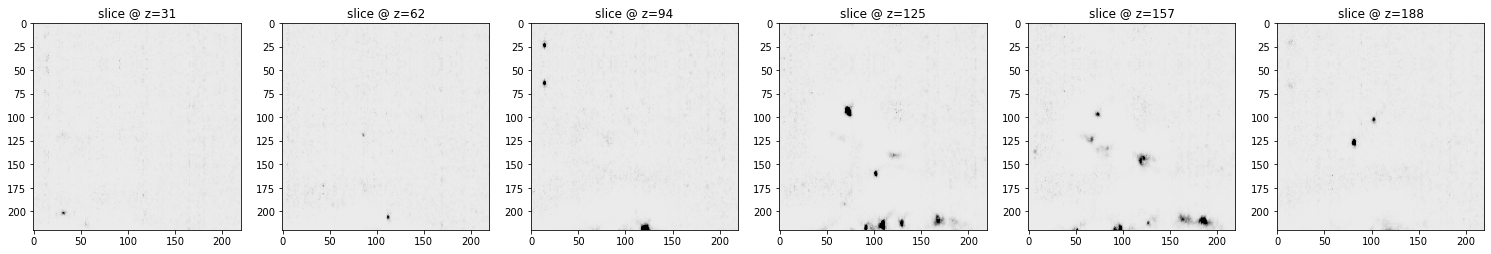

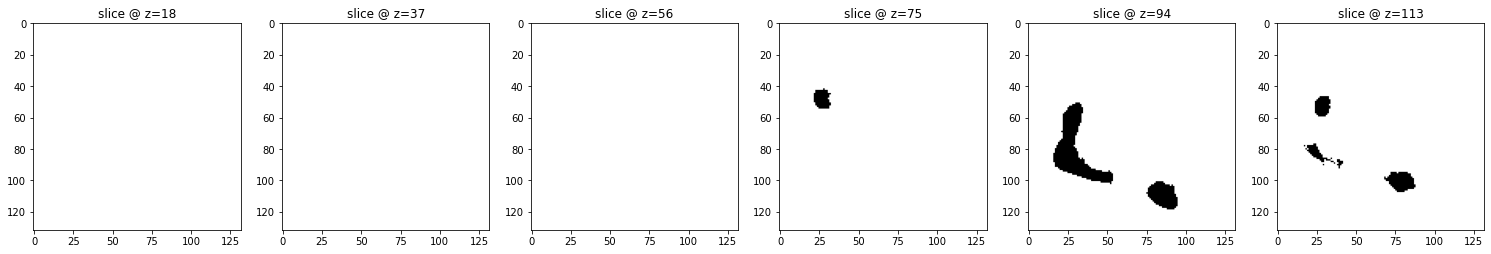

In [63]:
# Visualize an image mask pair from the validation set
im, msk = next(validationset_iter)
print(im.shape)
print(msk.shape)
visualization.showZSlices(im[0,...],channel=None, vmin=-2, vmax=10, n_slices=6)
visualization.showZSlices(msk[0,...,1], channel=None, vmin=0,vmax=1, n_slices=6)

## Load a pretrained model

In [15]:
## Restore a saved model if desired
#model_path = 'C:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\3D Unet\\VVDMaskNetwork\\VVDOvermask_0922'
model_path = 'C:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\3D Unet\\GapFilledMaskNetwork\\test.h5'
# Restore the trained model. Specify where keras can find custom objects that were used to build the unet
unet = tf.keras.models.load_model(model_path, compile=False,
                                  custom_objects={"InputBlock" : model.InputBlock,
                                                    "DownsampleBlock" : model.DownsampleBlock,
                                                    "BottleneckBlock" : model.BottleneckBlock,
                                                    "UpsampleBlock" : model.UpsampleBlock,
                                                    "OutputBlock" : model.OutputBlock})

In [16]:
unet.compile(loss = model.weighted_cce_dice_loss(class_weights=[1,5], dice_weight=0.3),
             metrics=['acc',metrics.MeanIoU(num_classes=2, name='meanIoU')])

In [29]:
## Generate Predictions for the validation dataset

loss, accuracy, iou = unet.evaluate(validationset, verbose=0)

In [30]:
print(iou)

0.86552554


In [21]:
y_true, y_pred = [],[]

validationset_iter = iter(validationset)
for im, msk in tqdm(validationset_iter):
    # get prediction for image
    pred = unet.predict(im)
    # convert to pseudoprobability
    pred = tf.nn.softmax(pred, axis=-1)
    y_pred.append(pred.numpy()[0,...,1])
    # get binary y_true from mask
    y_true.append(msk.numpy()[0,...,1])

y_true = np.stack(y_true, axis=0)
y_pred = np.stack(y_pred, axis=0)

30it [00:10,  2.81it/s]


In [22]:
y_true.shape

(30, 132, 132, 132)

In [36]:
def showOne():
    for n in range(n_val):
        visualization.showZSlices(y_pred[n,...],channel=None,vmin=0,vmax=1, n_slices=6)
        visualization.showZSlices(y_true[n,...],channel=None,vmin=0,vmax=1, n_slices=6)
        mask_overlay = visualization.makeRGBComposite(r=y_true[n,...,np.newaxis], g=y_pred[n,...,np.newaxis] ,b=None, gain=1.) # Make an overlay of the true mask (red) and the predicted mask (green)
        visualization.showZSlices(mask_overlay,n_slices=6, mode='rgb', title='True Mask @red Prediction @green')
        yield n

In [40]:
shower = showOne()

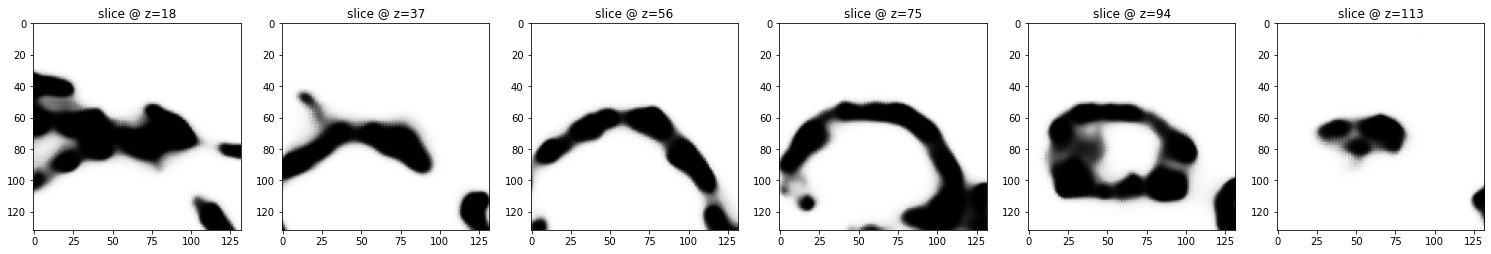

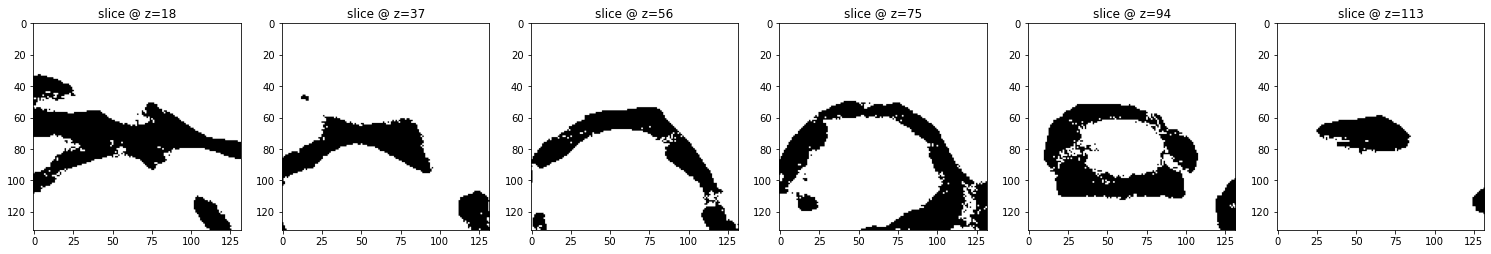

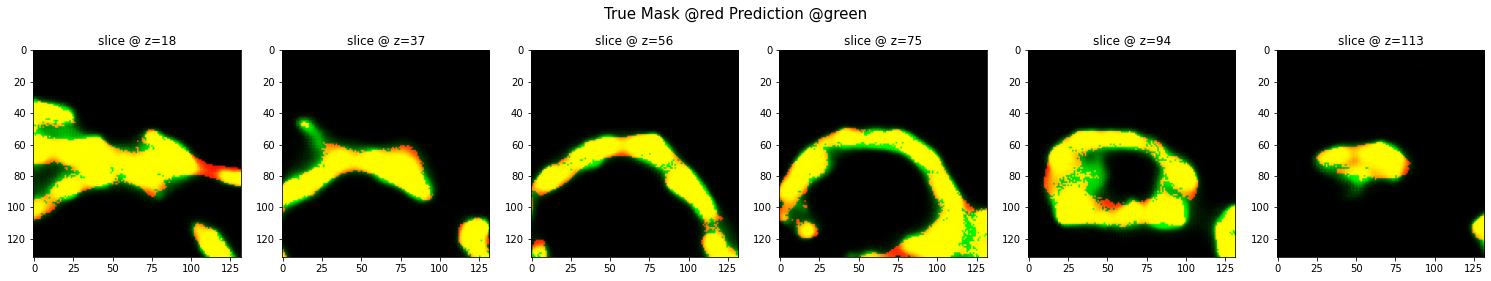

3

In [45]:
next(shower)

Text(0.1, 0.1, 'roc auc : 0.9971915927118742')

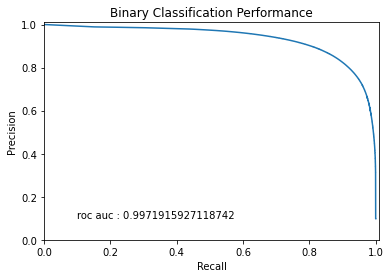

In [43]:
precision, recall, thresholds, auc = metrics.precisionRecall(y_true,y_pred)
plt.figure()
plt.plot(recall,precision)
plt.title('Binary Classification Performance')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0,1.01])
plt.ylim([0,1.01])
plt.text(0.1,0.1,'roc auc : {}'.format(auc))